In [184]:
# Connect to Database
import os

database_url = os.environ["database_url2"]
verbose = True

from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from sqlalchemy.ext.automap import automap_base

Base = automap_base()

engine = create_engine(database_url, echo=False)
Base.prepare(engine, reflect=True)

session = sessionmaker(bind=engine, autoflush=False)()


In [192]:
# Select Daten aus der stunden Datenbank
from sqlalchemy import func

ereignisse = ["K", "COR"]
zeitpunkt = "Monat Oktober 2021"

MitarbeiterEreignis = Base.classes.stunden_mitarbeiterereignis
Mitarbeiter = Base.classes.stunden_mitarbeiter
Kostenstelle = Base.classes.stunden_kostenstelle

q = session.query(Kostenstelle.kennung, func.count(Kostenstelle.kennung)).select_from(MitarbeiterEreignis).join(Mitarbeiter).join(Kostenstelle, Kostenstelle.id == Mitarbeiter.kostenstelle_id) \
    .filter(MitarbeiterEreignis.datum >= '2021-10-01', MitarbeiterEreignis.datum <= '2021-10-31')\
    .filter(MitarbeiterEreignis.ganztaegig.in_(ereignisse))\
    .order_by(Kostenstelle.kennung)\
    .group_by(Kostenstelle.kennung)
  
kostenstelle_ausfalltage = {d[0]: d[1] for d in list(q)}

if verbose:
    print(kostenstelle_ausfalltage)

{'0103': 12, '0104': 3, '0105': 7, '0107': 21, '0109': 5, '0113': 18, '0115': 7, '0116': 4, '0200': 1}


In [193]:
# Select Daten aus der stunden Datenbank
from sqlalchemy import func

MitarbeiterStunden = Base.classes.stunden_mitarbeiterstunden
Mitarbeiter = Base.classes.stunden_mitarbeiter
Kostenstelle = Base.classes.stunden_kostenstelle

q = session.query(Kostenstelle.kennung, func.count(Kostenstelle.kennung)).select_from(MitarbeiterStunden).join(Kostenstelle) \
    .filter(MitarbeiterStunden.datum >= '2021-10-01', MitarbeiterStunden.datum <= '2021-10-31')\
    .order_by(Kostenstelle.kennung) \
    .group_by(Kostenstelle.kennung)

kostenstelle_ausfuehrtage = {d[0]: d[1] for d in list(q)}

if verbose:
    print(kostenstelle_ausfuehrtage)
    

{'0101': 14, '0103': 114, '0104': 233, '0105': 206, '0107': 33, '0108': 20, '0109': 58, '0110': 34, '0111': 2, '0112': 160, '0113': 63, '0114': 33, '0115': 45, '0116': 96, '0120': 1, '0200': 57, '0201': 4}


In [194]:
# merge Listen Ausfalltage und Ausfühtage

q = session.query(Kostenstelle.kennung).order_by("kennung").all()
alle_kostenstellen = [k[0] for k in list(q)]

data = list()
for kostenstelle in alle_kostenstellen:
    # data.append({"kostenstelle": kostenstelle, "ausfuehrtage": kostenstelle_ausfuehrtage.get(kostenstelle, 0), "ausfalltage": kostenstelle_ausfalltage.get(kostenstelle, 0)})
    data.append({"Kostenstelle": kostenstelle, "Typ": "Ausführtage", "Anzahl": kostenstelle_ausfuehrtage.get(kostenstelle, 0)})
    data.append({"Kostenstelle": kostenstelle, "Typ": "Ausfalltage", "Anzahl": kostenstelle_ausfalltage.get(kostenstelle, 0)})

if verbose:
    print(data)

    

[{'Kostenstelle': '0101', 'Typ': 'Ausführtage', 'Anzahl': 14}, {'Kostenstelle': '0101', 'Typ': 'Ausfalltage', 'Anzahl': 0}, {'Kostenstelle': '0102', 'Typ': 'Ausführtage', 'Anzahl': 0}, {'Kostenstelle': '0102', 'Typ': 'Ausfalltage', 'Anzahl': 0}, {'Kostenstelle': '0103', 'Typ': 'Ausführtage', 'Anzahl': 114}, {'Kostenstelle': '0103', 'Typ': 'Ausfalltage', 'Anzahl': 12}, {'Kostenstelle': '0104', 'Typ': 'Ausführtage', 'Anzahl': 233}, {'Kostenstelle': '0104', 'Typ': 'Ausfalltage', 'Anzahl': 3}, {'Kostenstelle': '0105', 'Typ': 'Ausführtage', 'Anzahl': 206}, {'Kostenstelle': '0105', 'Typ': 'Ausfalltage', 'Anzahl': 7}, {'Kostenstelle': '0106', 'Typ': 'Ausführtage', 'Anzahl': 0}, {'Kostenstelle': '0106', 'Typ': 'Ausfalltage', 'Anzahl': 0}, {'Kostenstelle': '0107', 'Typ': 'Ausführtage', 'Anzahl': 33}, {'Kostenstelle': '0107', 'Typ': 'Ausfalltage', 'Anzahl': 21}, {'Kostenstelle': '0108', 'Typ': 'Ausführtage', 'Anzahl': 20}, {'Kostenstelle': '0108', 'Typ': 'Ausfalltage', 'Anzahl': 0}, {'Kostenstel

In [195]:
# DataFrame erstellen

import pandas as pd

data_frame = pd.DataFrame(data)

if verbose:
    print(data_frame)


   Kostenstelle          Typ  Anzahl
0          0101  Ausführtage      14
1          0101  Ausfalltage       0
2          0102  Ausführtage       0
3          0102  Ausfalltage       0
4          0103  Ausführtage     114
5          0103  Ausfalltage      12
6          0104  Ausführtage     233
7          0104  Ausfalltage       3
8          0105  Ausführtage     206
9          0105  Ausfalltage       7
10         0106  Ausführtage       0
11         0106  Ausfalltage       0
12         0107  Ausführtage      33
13         0107  Ausfalltage      21
14         0108  Ausführtage      20
15         0108  Ausfalltage       0
16         0109  Ausführtage      58
17         0109  Ausfalltage       5
18         0110  Ausführtage      34
19         0110  Ausfalltage       0
20         0111  Ausführtage       2
21         0111  Ausfalltage       0
22         0112  Ausführtage     160
23         0112  Ausfalltage       0
24         0113  Ausführtage      63
25         0113  Ausfalltage      18
2

In [200]:
import numpy as np

def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = '{:.1f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.1f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

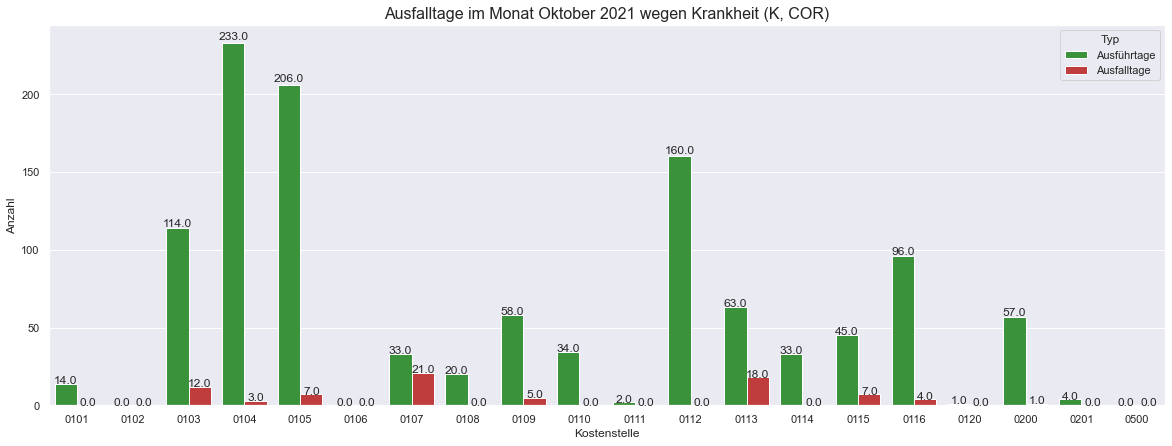

In [208]:
# Diagramm erstellen

import matplotlib.pyplot as plt
import seaborn as sn

sn.set(font_scale=1.0)
fig, ax = plt.subplots(figsize=(20,7))

palette = ['tab:green','tab:red']

p = sn.barplot(data = data_frame
            ,x = 'Kostenstelle'
            ,y = 'Anzahl'
            ,hue = 'Typ' 
            ,palette=palette
            )

ax.set_title(f"Ausfalltage im {zeitpunkt} wegen Krankheit ({', '.join(ereignisse)})", y=1, fontsize = 16)
show_values(p)
